In [1]:
import glob
import random
from csv import writer
from csv import reader
import pandas as pd
import os
import sys
os.chdir(os.path.split(os.getcwd())[0])


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
from infrarisk.src.network_recovery import *
import infrarisk.src.simulation as simulation
from infrarisk.src.network_sim_models.integrated_network import *
import infrarisk.src.hazard_initiator as hazard
from infrarisk.src.network_sim_models.interdependencies import *
from infrarisk.src.optimizer import *
import glob
import csv
import re
from csv import reader

#### Adding columns to the dataset

In [ ]:
# data_columns=['failure_power_lines',
#               'failure_power_trafo',
#               'failure_water_pipes',
#               'failure_water_pumps',
#               'failure_water_tanks',
#               'failure_transport_lines',
#               'power_travel_time',
#               'water_travel_time',
#               'transport_travel_time',
#               'weighed_auc',
#               'power_auc',
#               'water_auc']

# with open('datageneration/data/data_test.csv', 'w') as f:
#     # using csv.writer method from CSV package
#         write = csv.writer(f)
#         write.writerow(data_columns)
#         f.close()

#### Sorting the scenario files 

In [4]:
MAIN_DIR = Path('')
network_dir= 'infrarisk/data/networks/micropolis'
#scenario_folder = "scenarios/test*/*.csv"
#scenario_file = MAIN_DIR/f"{network_dir}/{scenario_folder}/"

directory_list = list()
for root, dirs, files in os.walk(f"{network_dir}/scenarios", topdown=False):
    for name in dirs:
        directory_list.append(name)

# dir_name='infrarisk/data/networks/micropolis/scenarios/test*/*.csv'
# list_of_files = filter(os.path.isfile,glob.glob(dir_name))
# # Sort list of files based on last modification time in ascending order
# list_of_files = sorted( list_of_files,
#                         key = os.path.getmtime)

#### Creating dataset by filtering out respective count of failed components, travel times and auc 

In [5]:
MAIN_DIR=Path('')
micropolis_network_original = IntegratedNetwork(name = 'Micropolis')

#network_dir= 'infrarisk/data/networks/micropolis'
water_file = MAIN_DIR/f'{network_dir}/water/water.inp'
power_file = MAIN_DIR/f'{network_dir}/power/power.json'
transp_folder = MAIN_DIR/f'{network_dir}/transportation/'

# load all infrastructure networks
micropolis_network_original.load_networks(water_file, power_file, transp_folder, power_sim_type = '3ph')
micropolis_network_original.generate_integrated_graph()
dependency_file = MAIN_DIR/f"{network_dir}/dependecies.csv"
micropolis_network_original.generate_dependency_table(dependency_file = dependency_file)

#set the crew initial location
micropolis_network_original.set_init_crew_locs(init_power_loc='T_J8',
init_water_loc='T_J8', init_transpo_loc='T_J8')

c:\Users\srijith\anaconda3\envs\redcar\lib\site-packages\wntr\epanet\io.py:2173: UserWarning: Not all curves were used in "infrarisk\data\networks\micropolis\water\water.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


Water network successfully loaded from infrarisk\data\networks\micropolis\water\water.inp. The analysis type is set to Pressure Dependent Demand Analysis.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from infrarisk\data\networks\micropolis\power\power.json. Three phase power flow simulation will be used.

Transportation network successfully loaded from infrarisk\data\networks\micropolis\transportation. Static traffic assignment method will be used to calculate travel times.
Successfully added power network to the integrated graph...
Successfully added water network to the integrated graph...
Successfully added transportation network to the integrated graph...
Integrated graph successffully created.


Loading BokehJS ...

In [6]:
for index, name in enumerate(directory_list[0:150]):
    
    try:
        micropolis_network = copy.deepcopy(micropolis_network_original)
        result_file = MAIN_DIR/f"{network_dir}/scenarios/{name}/network_performance.csv"
        if os.path.isfile(result_file) == False:
            with open(f"{network_dir}/scenarios/{name}/disruption_file.csv", 'r') as file:
                components=[]
                data=[]
                count_pl=count_tf=count_wp=count_wpipe=count_wt=count_tl=0
                reader = csv.reader(file)
                header = next(reader)
                if header != None:
                    for row in reader:
                        components.append(row[1])
                print(f"{index}:  Simulating the repair sequence {components}")
                #dict_new={}
                for i in range (0,len(components)):
                    power_line=re.findall('P_L[0-9]*$', components[i])
                    if power_line:
                        count_pl=count_pl+1

                    power_transfo=re.findall('P_TF[0-9]*$',components[i])
                    if power_transfo:
                        count_tf=count_tf+1

                    water_pipe=re.findall('W_PMA[0-9]*$',components[i])
                    if water_pipe:
                        count_wpipe=count_wpipe+1

                    water_pump=re.findall('W_WP[0-9]*$',components[i])
                    if water_pump:
                        count_wp=count_wp+1

                    water_tank=re.findall('W_T[0-9]*$',components[i])
                    if water_tank:
                        count_wt=count_wt+1

                    transpo_link=re.findall('T_L[0-9]*$',components[i])
                    if transpo_link:
                        count_tl=count_tl+1
                        
                #assign the scenario file 
                scenario_file = f"{network_dir}/scenarios/{name}/disruption_file.csv"
                #set disrupted components
                micropolis_network.set_disrupted_components(scenario_file=scenario_file)
                micropolis_network.get_disrupted_components()
                micropolis_network.pipe_leak_node_generator()

                network_recovery = NetworkRecovery(micropolis_network, sim_step=60)
                sim_step = (micropolis_network.wn.options.time.hydraulic_timestep) 

                # initial_sim_step which will be updated during the simulation
                bf_simulation = simulation.NetworkSimulation(network_recovery, sim_step)

                #Generate a random repair order
                repair_order = network_recovery.network.get_disrupted_components()

                #random.shuffle(repair_order)        
                bf_simulation.network_recovery.schedule_recovery(repair_order)
                power_travel_time=network_recovery.power_crew_total_tt
                water_travel_time=network_recovery.water_crew_total_tt
                transport_travel_time=network_recovery.transpo_crew_total_tt

                bf_simulation.network_recovery.get_event_table()
                bf_simulation.expand_event_table(5)
                #Simulation of interdependent effects
                resilience_metrics = bf_simulation.simulate_interdependent_effects( bf_simulation.network_recovery)
                resilience_metrics.set_weighted_auc_metrics()

                weighed_auc=round(resilience_metrics.weighed_auc, 3)
                power_auc=round(resilience_metrics.power_auc, 3)
                water_auc=round(resilience_metrics.water_auc, 3)
                
                time_tracker, power_consump_tracker, water_consump_tracker = (
                    resilience_metrics.time_tracker, 
                    resilience_metrics.power_consump_tracker, 
                    resilience_metrics.water_consump_tracker
                )
                
                bf_simulation.write_results(time_tracker, 
                                            power_consump_tracker, 
                                            water_consump_tracker,
                                            result_file)

                data=[count_pl,count_tf,count_wpipe,count_wp,count_wt,count_tl,power_travel_time,water_travel_time,transport_travel_time,weighed_auc,power_auc,water_auc]
                with open('datageneration/data/data_test.csv', 'a',encoding='utf-8',newline='\n') as f:
                    write = csv.writer(f)
                    write.writerow(data)
        else:
            print(f"Skip {name}")
    except:
        print("Oops!", sys.exc_info()[0], "occurred.")
        print("Next entry.")
        print()

In [9]:
#redundnacy calculations
 

for index, name in enumerate(directory_list[0:150]):
    
    try:
        micropolis_network = copy.deepcopy(micropolis_network_original)
        result_file = MAIN_DIR/f"{network_dir}/scenarios/{name}/network_performance.csv"
        if os.path.isfile(result_file) == True:
            with open(f"{network_dir}/scenarios/{name}/disruption_file.csv", 'r') as file:
                components=[]
                reader = csv.reader(file)
                header = next(reader)
                if header != None:
                    for row in reader:
                        components.append(row[1])
                print(f"{index}:  Simulating the repair sequence {components}")
                #dict_new={}
                        
                #assign the scenario file 
                scenario_file = f"{network_dir}/scenarios/{name}/disruption_file.csv"
                #set disrupted components
                micropolis_network.set_disrupted_components(scenario_file=scenario_file)
                micropolis_network.get_disrupted_components()
                micropolis_network.pipe_leak_node_generator()

                network_recovery = NetworkRecovery(micropolis_network, sim_step=60)
                sim_step = (micropolis_network.wn.options.time.hydraulic_timestep) 

                # initial_sim_step which will be updated during the simulation
                bf_simulation = simulation.NetworkSimulation(network_recovery, sim_step)

                #Generate a random repair order
                repair_order = network_recovery.network.get_disrupted_components()

                #random.shuffle(repair_order)        
                bf_simulation.network_recovery.schedule_recovery(repair_order)
                power_travel_time=network_recovery.power_crew_total_tt
                water_travel_time=network_recovery.water_crew_total_tt
                transport_travel_time=network_recovery.transpo_crew_total_tt

                bf_simulation.network_recovery.get_event_table()
                bf_simulation.expand_event_table(5)
                #Simulation of interdependent effects
                resilience_metrics = bf_simulation.simulate_interdependent_effects( bf_simulation.network_recovery)
                resilience_metrics.set_weighted_auc_metrics()

                weighed_auc=round(resilience_metrics.weighed_auc, 3)
                power_auc=round(resilience_metrics.power_auc, 3)
                water_auc=round(resilience_metrics.water_auc, 3)
                
                time_tracker, power_consump_tracker, water_consump_tracker = (
                    resilience_metrics.time_tracker, 
                    resilience_metrics.power_consump_tracker, 
                    resilience_metrics.water_consump_tracker
                )
                
                bf_simulation.write_results(time_tracker, 
                                            power_consump_tracker, 
                                            water_consump_tracker,
                                            result_file)

                data=[count_pl,count_tf,count_wpipe,count_wp,count_wt,count_tl,power_travel_time,water_travel_time,transport_travel_time,weighed_auc,power_auc,water_auc]
                with open('datageneration/data/data_test.csv', 'a',encoding='utf-8',newline='\n') as f:
                    write = csv.writer(f)
                    write.writerow(data)
        else:
            print(f"Skip {name}")
    except:
        print("Oops!", sys.exc_info()[0], "occurred.")
        print("Next entry.")
        print()

False

In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [30]:
import pandas as pd
sim_data=pd.read_csv("C:/Users/srijith/Desktop/data_test.csv")

In [31]:
sim_data.head()

,failure_power_lines,failure_power_trafo,failure_water_pipes,failure_water_pumps,failure_water_tanks,failure_transport_lines,power_travel_time,water_travel_time,transport_travel_time,weighed_auc,power_auc,water_auc
0,0,1,1,0,0,1,18,18,18,1522.471,1559.462,1485.480
1,2,1,2,0,0,1,38,28,18,1519.577,1543.565,1495.588
2,1,4,3,0,0,1,59,38,18,2712.184,2846.297,2578.070
3,0,2,0,0,0,0,27,0,0,1308.511,1327.432,1289.591
4,2,3,1,0,0,0,60,18,0,2480.643,2504.914,2456.373


In [91]:
sim_data_reduced = sim_data[["failure_power_lines",
             #"failure_power_trafo",	
             "failure_water_pipes",	
             "failure_water_pumps",	
             "failure_water_tanks",	
             "failure_transport_lines",	
             #"power_travel_time",	
             #"water_travel_time",	
             #"transport_travel_time",
             "weighed_auc"
             ]]

features = sim_data[["failure_power_lines",
             #"failure_power_trafo",	
             "failure_water_pipes",	
             "failure_water_pumps",	
             "failure_water_tanks",	
             "failure_transport_lines",	
             #"power_travel_time",	
             #"water_travel_time",	
             #"transport_travel_time"
             ]]

labels = sim_data['weighed_auc']

In [92]:
train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, test_size=0.20, random_state=43
    )
print("Training Features Shape:", train_features.shape)
print("Training Labels Shape:", train_labels.shape)
print("Testing Features Shape:", test_features.shape)
print("Testing Labels Shape:", test_labels.shape)

Training Features Shape: (379, 5)
Training Labels Shape: (379,)
Testing Features Shape: (95, 5)
Testing Labels Shape: (95,)


In [93]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
regressor = RandomForestRegressor(n_estimators = 500, max_depth=None, random_state = 0)

In [94]:
regressor.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=500, random_state=0)

In [95]:
y_pred = regressor.predict(test_features)

In [96]:
# Evaluating the Algorithm
from sklearn import metrics
import numpy as np
import matplotlib as plt

print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, y_pred)))
print('R2 value:', metrics.r2_score(test_labels, y_pred))

Mean Absolute Error: 1215.403112692439
Mean Squared Error: 2791233.3078739946
Root Mean Squared Error: 1670.6984491146195
R2 value: 0.5875176923246803


<AxesSubplot:>

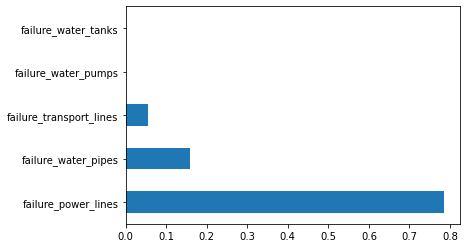

In [97]:
feat_importances = pd.Series(regressor.feature_importances_, index=features.columns)
feat_importances.nlargest(9).plot(kind='barh')

In [51]:
from sklearn.metrics import r2_score

tuned_parameters = {'n_estimators': [500, 700, 1000], 'max_depth': [None, 1, 2, 3]}

clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, scoring=r2_score, n_jobs=-1, verbose=1)
clf.fit(train_features, train_labels)
print(clf.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\srijith\anaconda3\envs\public_transit\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


RandomForestRegressor(n_estimators=500)


In [52]:
clf.best_params_

{'max_depth': None, 'n_estimators': 500}

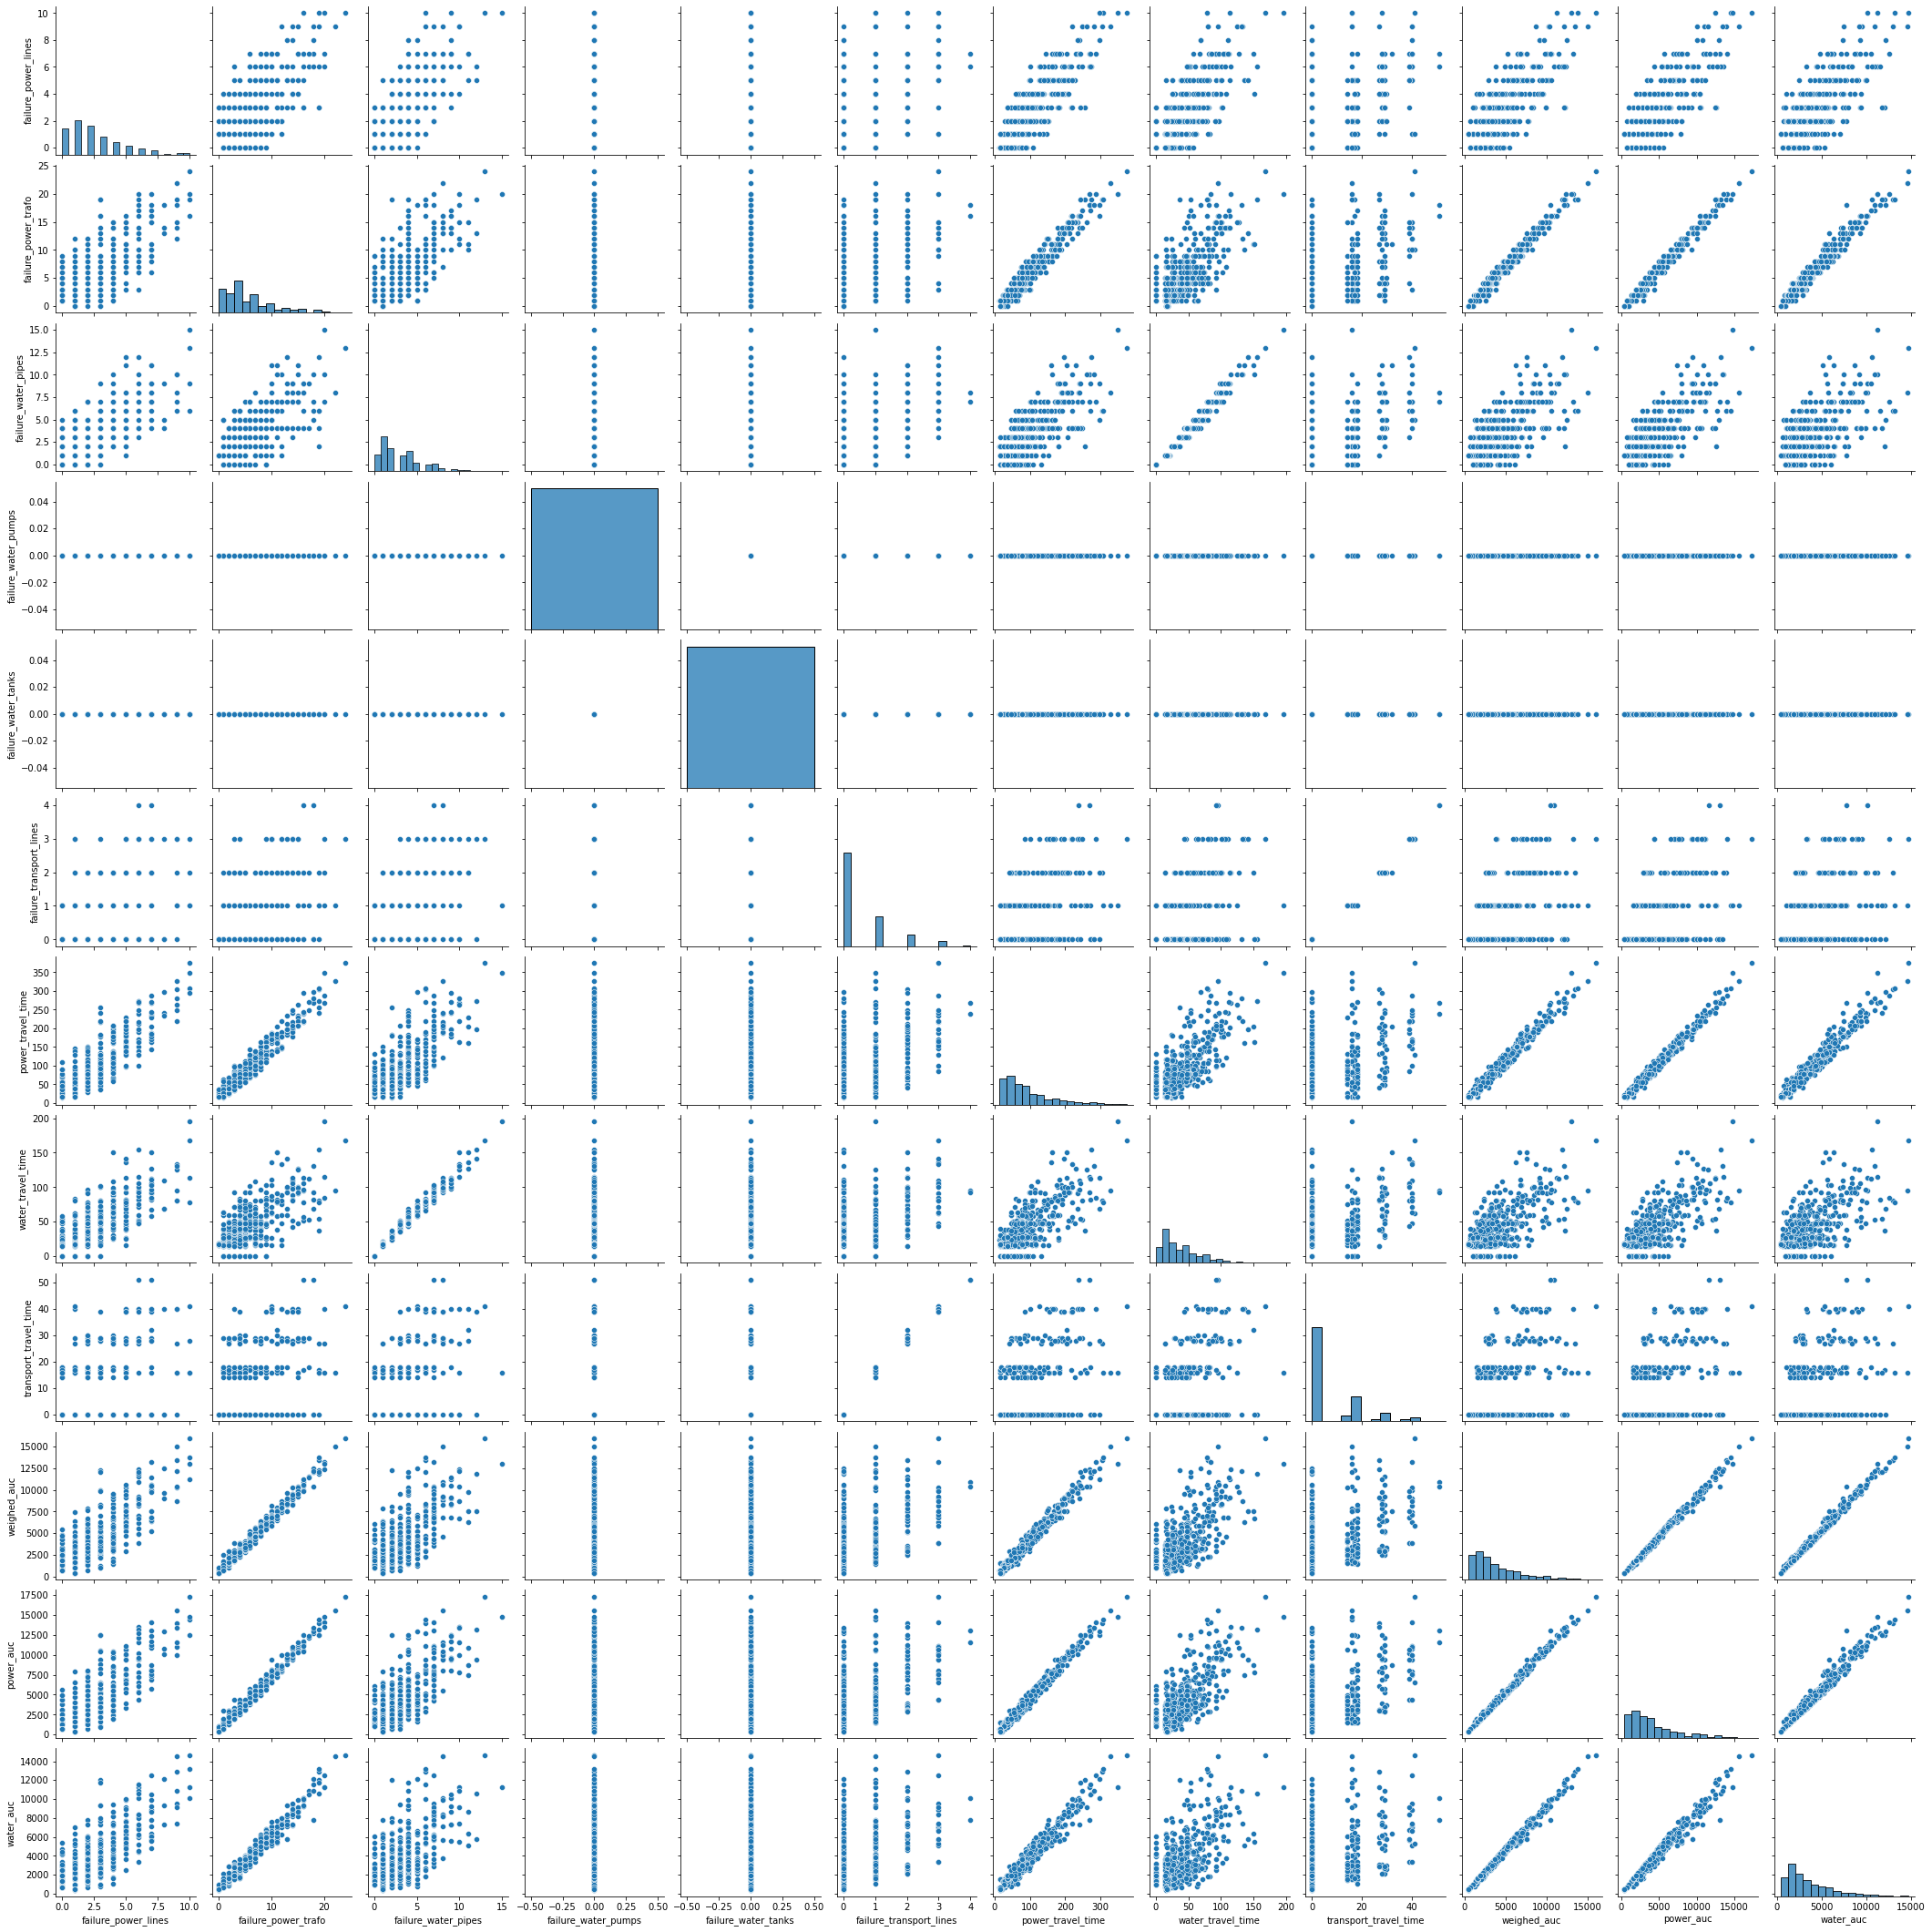

In [61]:
import seaborn as sns

sns.pairplot(sim_data)

<AxesSubplot:>

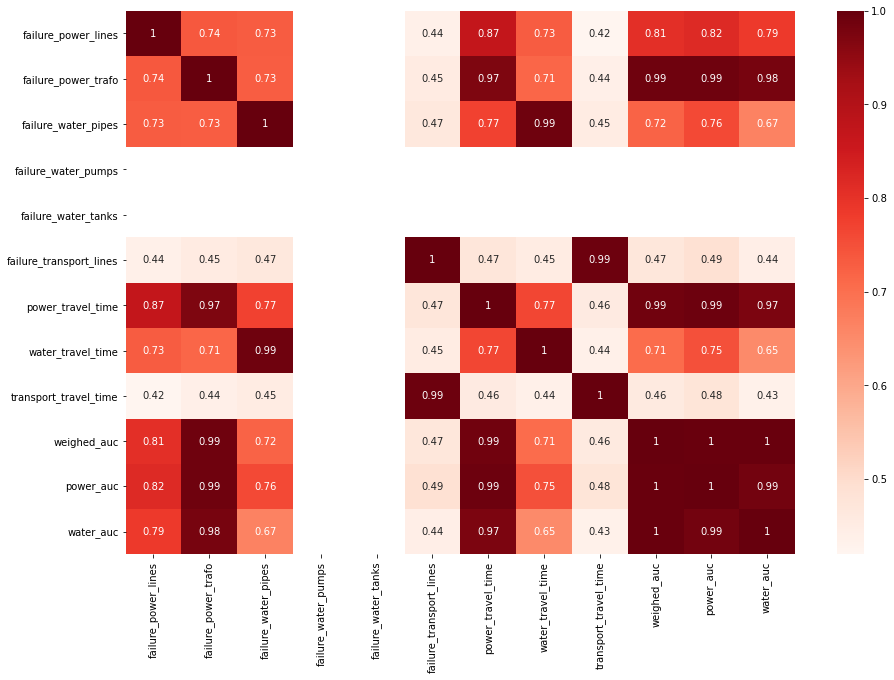

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.heatmap(sim_data.corr(), annot=True, cmap='Reds')

<AxesSubplot:xlabel='water_auc', ylabel='Count'>

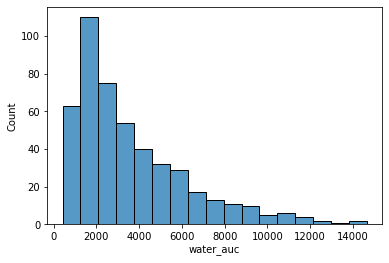

In [66]:
sns.histplot(data=sim_data, x= "water_auc")

<AxesSubplot:xlabel='power_auc', ylabel='Count'>

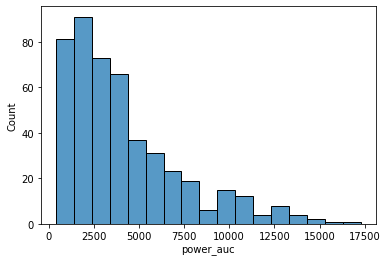

In [64]:
sns.histplot(data=sim_data, x="power_auc")

<AxesSubplot:xlabel='failure_water_pipes', ylabel='water_auc'>

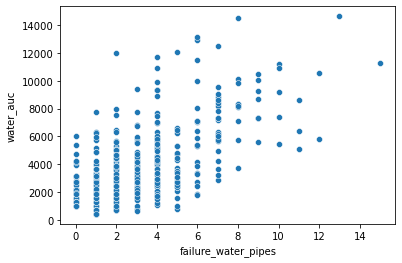

In [67]:
sns.scatterplot(data= sim_data, x="failure_water_pipes", y = "water_auc")

<AxesSubplot:xlabel='failure_power_lines', ylabel='power_auc'>

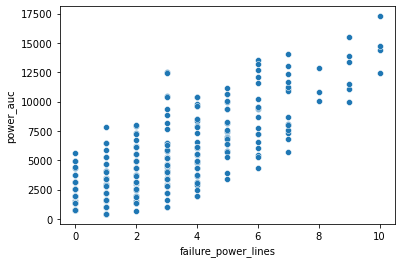

In [85]:
sns.scatterplot(data= sim_data, x="failure_power_lines", y = "power_auc")